# Use Categorical DQN to Play Pong-v4

PyTorch version

In [1]:
%matplotlib inline

import copy
import logging
import itertools
import sys

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
from gym.wrappers.atari_preprocessing import AtariPreprocessing
from gym.wrappers.frame_stack import FrameStack
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
from torch import nn
from torch import optim

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

Environment

In [2]:
env = gym.make('PongNoFrameskip-v4', new_step_api=True)
env = FrameStack(AtariPreprocessing(env), num_stack=4)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

11:37:24 [INFO] env: <AtariPreprocessing<TimeLimit<AtariEnv<PongNoFrameskip-v4>>>>
11:37:24 [INFO] action_space: Discrete(6)
11:37:24 [INFO] observation_space: : Box([[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]], [[[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 

Agent

In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'termination'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = np.asarray(args, dtype=object)
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class CategoricalDQNAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99
        self.epsilon = 1.  # exploration

        self.replayer = DQNReplayer(capacity=100000)

        self.atom_count = 51
        self.atom_min = -10.
        self.atom_max = 10.
        self.atom_difference = (self.atom_max - self.atom_min) \
                / (self.atom_count - 1)
        self.atom_tensor = torch.linspace(self.atom_min, self.atom_max,
                self.atom_count)

        self.evaluate_net = nn.Sequential(
                nn.Conv2d(4, 32, kernel_size=8, stride=4), nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU(),
                nn.Flatten(),
                nn.Linear(3136, 512), nn.ReLU(inplace=True),
                nn.Linear(512, self.action_n * self.atom_count))
        self.target_net = copy.deepcopy(self.evaluate_net)
        self.optimizer = optim.Adam(self.evaluate_net.parameters(), lr=0.0001)

    def reset(self, mode=None):
        self.mode = mode
        if mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, termination):
        state_tensor = torch.as_tensor(observation,
                dtype=torch.float).unsqueeze(0)
        logit_tensor = self.evaluate_net(state_tensor).view(-1, self.action_n,
                self.atom_count)
        prob_tensor = logit_tensor.softmax(dim=-1)
        q_component_tensor = prob_tensor * self.atom_tensor
        q_tensor = q_component_tensor.mean(2)
        action_tensor = q_tensor.argmax(dim=1)
        actions = action_tensor.detach().numpy()
        action = actions[0]
        if self.mode == 'train':
            if np.random.rand() < self.epsilon:
                action = np.random.randint(0, self.action_n)
            
            self.trajectory += [observation, reward, termination, action]
            if len(self.trajectory) >= 8:
                state, _, _, act, next_state, reward, termination, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, act, reward, next_state, termination)
            if self.replayer.count >= 1024 and self.replayer.count % 10 == 0:
                self.learn()
        return action

    def close(self):
        pass

    def update_net(self, target_net, evaluate_net, learning_rate=0.005):
        for target_param, evaluate_param in zip(
                target_net.parameters(), evaluate_net.parameters()):
            target_param.data.copy_(learning_rate * evaluate_param.data
                    + (1 - learning_rate) * target_param.data)

    def learn(self):
        # replay
        batch_size = 32
        states, actions, rewards, next_states, terminations = \
                self.replayer.sample(batch_size)
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        reward_tensor = torch.as_tensor(rewards, dtype=torch.float)
        termination_tensor = torch.as_tensor(terminations, dtype=torch.float)
        next_state_tensor = torch.as_tensor(next_states, dtype=torch.float)

        # compute target
        next_logit_tensor = self.target_net(next_state_tensor).view(-1,
                self.action_n, self.atom_count)
        next_prob_tensor = next_logit_tensor.softmax(dim=-1)
        next_q_tensor = (next_prob_tensor * self.atom_tensor).sum(2)
        next_action_tensor = next_q_tensor.argmax(dim=1)
        next_actions = next_action_tensor.detach().numpy()
        next_dist_tensor = next_prob_tensor[np.arange(batch_size),
                next_actions, :].unsqueeze(1)
        
        # project
        target_tensor = reward_tensor.reshape(batch_size, 1) + self.gamma \
                * self.atom_tensor.repeat(batch_size, 1) \
                * (1. - termination_tensor).reshape(-1, 1)
        clipped_target_tensor = target_tensor.clamp(self.atom_min,
                self.atom_max)
        projection_tensor = (1. - (clipped_target_tensor.unsqueeze(1)
                - self.atom_tensor.view(1, -1, 1)).abs()
                / self.atom_difference).clamp(0, 1)
        projected_tensor = (projection_tensor * next_dist_tensor).sum(-1)

        logit_tensor = self.evaluate_net(state_tensor).view(-1, self.action_n,
                self.atom_count)
        all_q_prob_tensor = logit_tensor.softmax(dim=-1)
        q_prob_tensor = all_q_prob_tensor[range(batch_size), actions, :]

        cross_entropy_tensor = -torch.xlogy(projected_tensor, q_prob_tensor
                + 1e-8).sum(1)
        loss_tensor = cross_entropy_tensor.mean()
        self.optimizer.zero_grad()
        loss_tensor.backward()
        self.optimizer.step()

        self.update_net(self.target_net, self.evaluate_net)

        self.epsilon = max(self.epsilon - 1e-5, 0.05)


agent = CategoricalDQNAgent(env)

Train & Test

11:37:24 [INFO] ==== train ====
11:37:47 [INFO] train episode 0: reward = -19.00, steps = 1095
11:38:20 [INFO] train episode 1: reward = -20.00, steps = 945
11:38:53 [INFO] train episode 2: reward = -20.00, steps = 917
11:39:25 [INFO] train episode 3: reward = -21.00, steps = 879
11:39:56 [INFO] train episode 4: reward = -21.00, steps = 863
11:40:28 [INFO] train episode 5: reward = -20.00, steps = 837
11:41:05 [INFO] train episode 6: reward = -20.00, steps = 925
11:41:41 [INFO] train episode 7: reward = -20.00, steps = 966
11:42:12 [INFO] train episode 8: reward = -21.00, steps = 785
11:42:41 [INFO] train episode 9: reward = -21.00, steps = 757
11:43:16 [INFO] train episode 10: reward = -19.00, steps = 919
11:43:53 [INFO] train episode 11: reward = -20.00, steps = 960
11:44:24 [INFO] train episode 12: reward = -21.00, steps = 761
11:44:55 [INFO] train episode 13: reward = -21.00, steps = 816
11:45:25 [INFO] train episode 14: reward = -21.00, steps = 762
11:46:02 [INFO] train episode 15

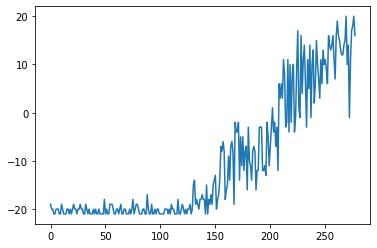

In [5]:
def play_episode(env, agent, seed=None, mode=None, render=False):
    observation = env.reset(seed=seed)
    reward, termination, truncation = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, termination)
        if render:
            env.render()
        if termination or truncation:
            break
        observation, reward, termination, truncation, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, mode='train')
    episode_rewards.append(episode_reward)
    logging.info('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-5:]) > 16.:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))